In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




In [6]:
DATA_PATH = "/content/heart.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())
display(df.describe().T)




Shape: (1025, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


In [7]:
print("Missing values per column:\n", df.isna().sum())
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

obj_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns detected:", obj_cols)

if obj_cols:
    X = pd.get_dummies(X, columns=obj_cols, drop_first=True)
    print("After one-hot, X shape:", X.shape)


Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Categorical columns detected: []


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (820, 13) Test size: (205, 13)


In [9]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

train_acc = accuracy_score(y_train, dt.predict(X_train))
test_acc = accuracy_score(y_test, dt.predict(X_test))
print(f"Baseline Decision Tree -> train acc: {train_acc:.4f}, test acc: {test_acc:.4f}")


Baseline Decision Tree -> train acc: 1.0000, test acc: 0.9854


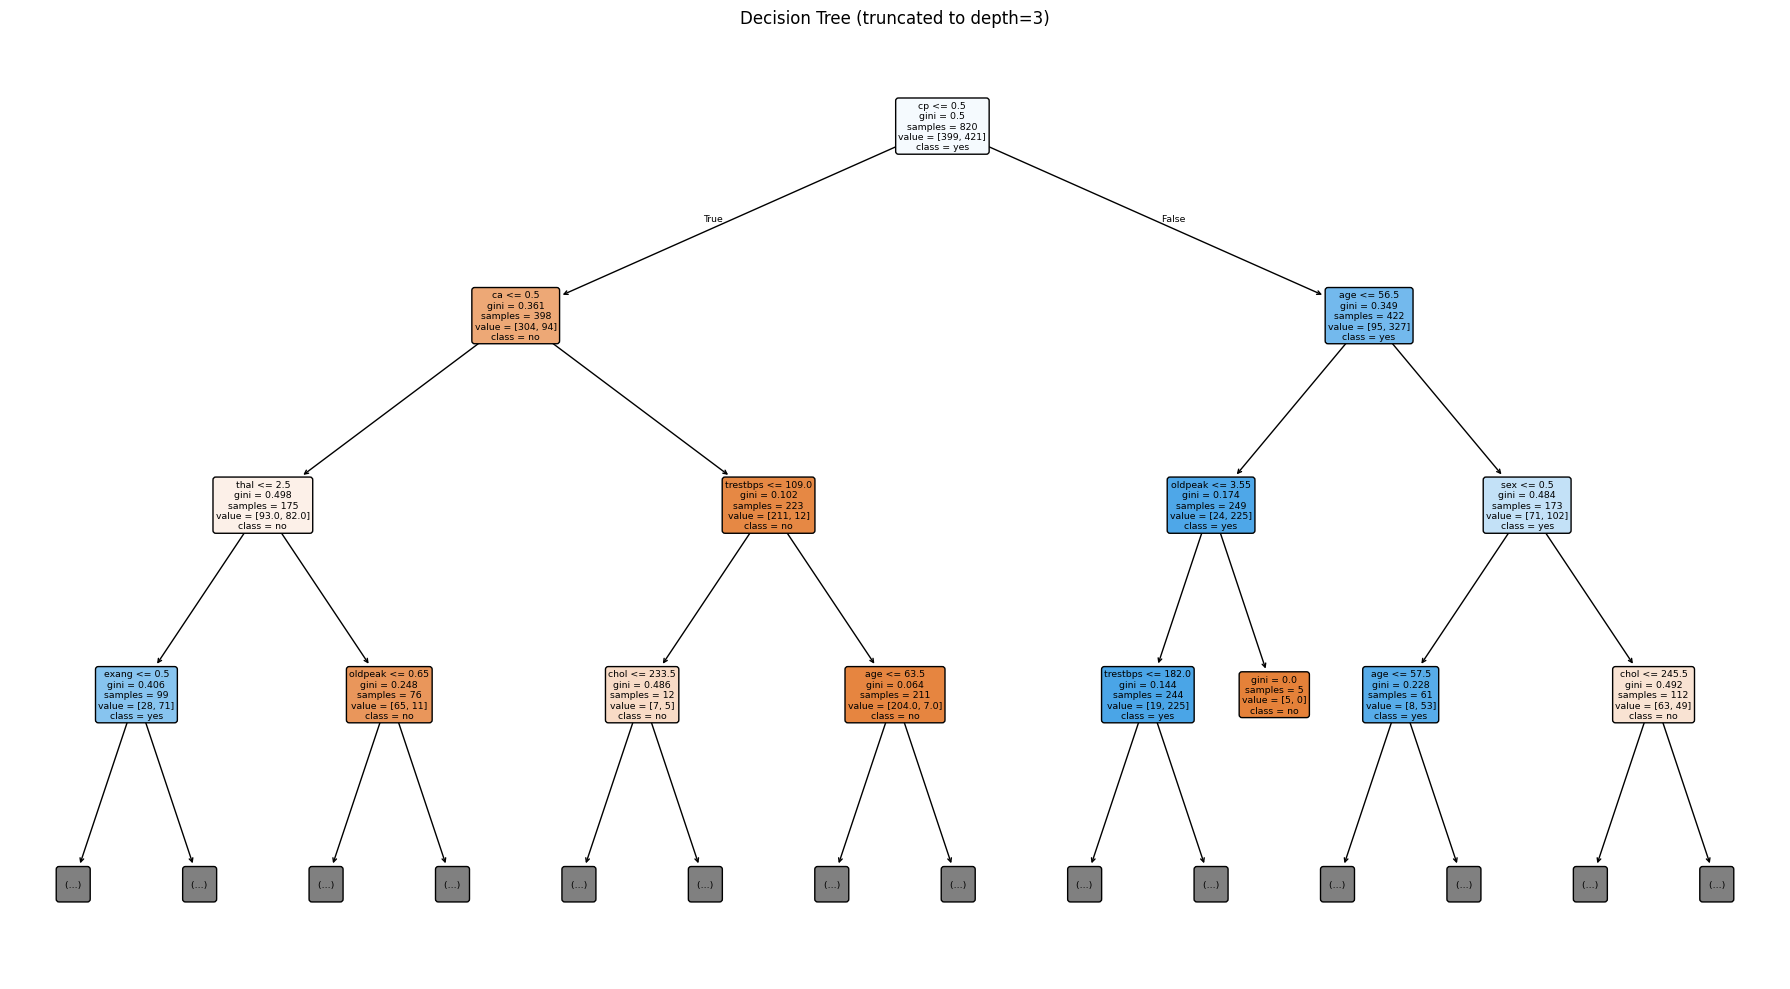

Wrote: outputs/tree_full.dot


In [10]:
plt.figure(figsize=(18,10))
plot_tree(dt, feature_names=X.columns, class_names=['no','yes'],
          filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree (truncated to depth=3)")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "dt_tree_truncated.png"))
plt.show()

export_graphviz(dt, out_file=os.path.join(OUTDIR, "tree_full.dot"),
                feature_names=X.columns, class_names=['no','yes'],
                rounded=True, filled=True)
print("Wrote:", os.path.join(OUTDIR, "tree_full.dot"))


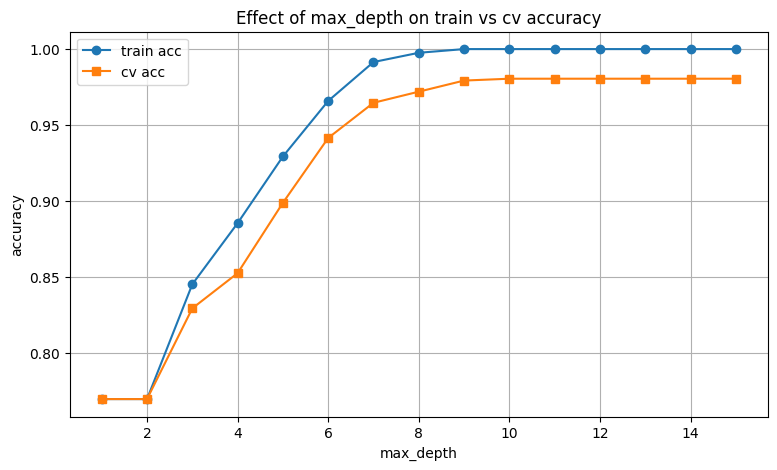

Best max_depth by CV: 10 with CV acc: 0.9804878048780488


In [11]:
depths = list(range(1, 16))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
train_scores = []
cv_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    cv_score = cross_val_score(clf, X_train, y_train, cv=cv, scoring="accuracy").mean()
    cv_scores.append(cv_score)
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))

plt.figure(figsize=(9,5))
plt.plot(depths, train_scores, marker='o', label='train acc')
plt.plot(depths, cv_scores, marker='s', label='cv acc')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Effect of max_depth on train vs cv accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTDIR, "depth_vs_accuracy.png"))
plt.show()

best_depth = depths[int(np.argmax(cv_scores))]
print("Best max_depth by CV:", best_depth, "with CV acc:", max(cv_scores))


In [12]:
dt_pruned = DecisionTreeClassifier(max_depth=best_depth, random_state=RANDOM_STATE)
dt_pruned.fit(X_train, y_train)

print("Pruned tree train acc:", accuracy_score(y_train, dt_pruned.predict(X_train)))
print("Pruned tree test acc: ", accuracy_score(y_test, dt_pruned.predict(X_test)))

print("Pruned tree classification report:\n", classification_report(y_test, dt_pruned.predict(X_test)))
print("Confusion matrix:\n", confusion_matrix(y_test, dt_pruned.predict(X_test)))


Pruned tree train acc: 1.0
Pruned tree test acc:  0.9853658536585366
Pruned tree classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

Confusion matrix:
 [[100   0]
 [  3 102]]


In [13]:
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

print("RF train acc:", accuracy_score(y_train, rf.predict(X_train)))
print("RF test acc: ", accuracy_score(y_test, rf.predict(X_test)))
print("RF classification report:\n", classification_report(y_test, rf.predict(X_test)))


RF train acc: 1.0
RF test acc:  1.0
RF classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



In [15]:
models = {
    f"DecisionTree_d{best_depth}": DecisionTreeClassifier(max_depth=best_depth, random_state=RANDOM_STATE),
    "RandomForest_200": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy", n_jobs=-1)
    print(f"{name} -> CV mean acc: {scores.mean():.4f}, std: {scores.std():.4f}")


DecisionTree_d10 -> CV mean acc: 1.0000, std: 0.0000
RandomForest_200 -> CV mean acc: 0.9971, std: 0.0059


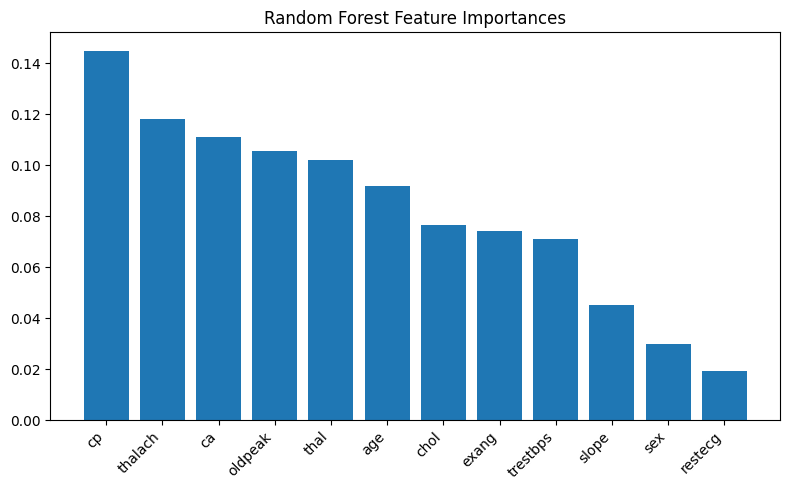

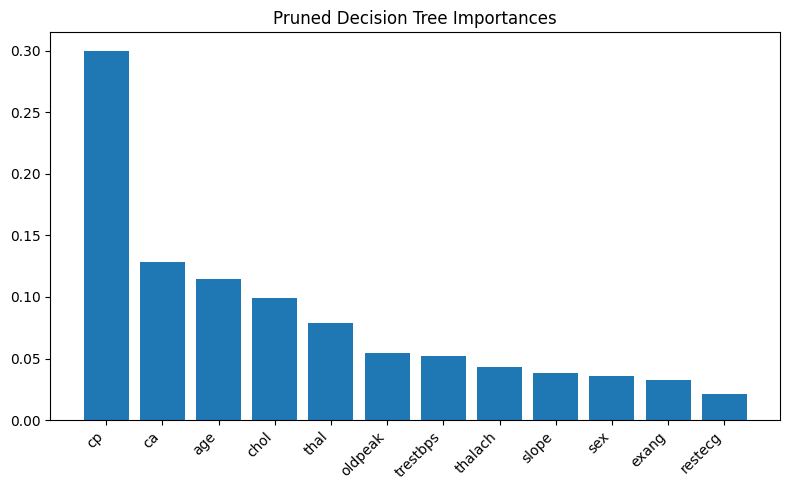

RF top 5:
     feature  importance
2        cp    0.144796
7   thalach    0.118097
11       ca    0.110965
9   oldpeak    0.105590
12     thal    0.101825
DT top 5:
    feature  importance
2       cp    0.299922
11      ca    0.128631
0      age    0.114920
4     chol    0.099451
12    thal    0.079146


In [16]:
def plot_importances(importances, feature_names, title, fname, top_n=12):
    order = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(8,5))
    plt.bar(range(len(order)), importances[order])
    plt.xticks(range(len(order)), feature_names[order], rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname))
    plt.show()

rf_importances = rf.feature_importances_
plot_importances(rf_importances, X.columns.values, "Random Forest Feature Importances", "rf_importances.png")

dt_importances = dt_pruned.feature_importances_
plot_importances(dt_importances, X.columns.values, "Pruned Decision Tree Importances", "dt_importances.png")

rf_imp_df = pd.DataFrame({"feature": X.columns, "importance": rf_importances}).sort_values("importance", ascending=False)
dt_imp_df = pd.DataFrame({"feature": X.columns, "importance": dt_importances}).sort_values("importance", ascending=False)
print("RF top 5:\n", rf_imp_df.head())
print("DT top 5:\n", dt_imp_df.head())


In [17]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 6, 10],
    "max_features": ["sqrt", "log2"]
}
grid = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                    param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best RF params:", grid.best_params_)
print("Best CV score:", grid.best_score_)
best_rf = grid.best_estimator_
print("Best RF test acc:", accuracy_score(y_test, best_rf.predict(X_test)))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Best CV score: 0.9707494452019999
Best RF test acc: 1.0
